In [38]:
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from skimage import*
import tensorflow as tf
from skimage.transform import resize
import tensorflow as tf
from keras.applications import vgg16
from keras import backend as K
from scipy.misc import imresize
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

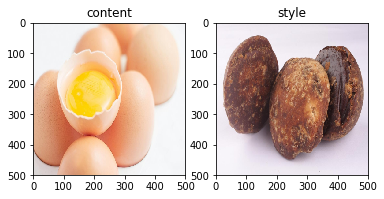

In [39]:
DATA_DIR = "datasets/"
DATA_DIR1 = "datasets/"
CONTENT_IMAGE_FILE = os.path.join(DATA_DIR, "src1.jpg")
img = plt.imread(CONTENT_IMAGE_FILE)
plt.imshow(img)


STYLE_IMAGE_FILE = os.path.join(DATA_DIR1, "src2.jpg")
RESIZED_WH = 500

content_img_value = imresize(plt.imread(CONTENT_IMAGE_FILE), (RESIZED_WH, RESIZED_WH))
style_img_value = imresize(plt.imread(STYLE_IMAGE_FILE), (RESIZED_WH, RESIZED_WH))

plt.subplot(121)
plt.title("content")
plt.imshow(content_img_value)

plt.subplot(122)
plt.title("style")
plt.imshow(style_img_value)

plt.show()


In [40]:
def preprocess(img):
    img4d = img.copy()
    img4d = img4d.astype("float64")
    if K.image_dim_ordering() == "th":
        # (H, W, C) -> (C, H, W)
        img4d = img4d.transpose((2, 0, 1))
    img4d = np.expand_dims(img4d, axis=0)
    img4d = vgg16.preprocess_input(img4d)
    return img4d

def deprocess(img4d):
    img = img4d.copy()
    if K.image_dim_ordering() == "th":
        # (B, C, H, W)
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
        img = img.transpose((1, 2, 0))
    else:
        # (B, H, W, C)
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # BGR -> RGB
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img
        

In [41]:
content_img = K.variable(preprocess(content_img_value))
style_img = K.variable(preprocess(style_img_value))
if K.image_dim_ordering() == "th":
    comb_img = K.placeholder((1, 3, RESIZED_WH, RESIZED_WH))
else:
    comb_img = K.placeholder((1, RESIZED_WH, RESIZED_WH, 3))

# concatenate images into single input
input_tensor = K.concatenate([content_img, style_img, comb_img], axis=0)

model = vgg16.VGG16(input_tensor=input_tensor, weights="imagenet", include_top=False)
layer_dict = {layer.name : layer.output for layer in model.layers}

In [42]:
def content_loss(content, comb):
    return K.sum(K.square(comb - content))

def gram_matrix(x):
    if K.image_dim_ordering() == "th":
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss_per_layer(style, comb):
    S = gram_matrix(style)
    C = gram_matrix(comb)
    channels = 3
    size = RESIZED_WH * RESIZED_WH
    return K.sum(K.square(S - C)) / (4 * (channels ** 2) * (size ** 2))

def style_loss():
    stl_loss = 0.0
    for i in range(NUM_LAYERS):
        layer_name = "block{:d}_conv1".format(i+1)
        layer_features = layer_dict[layer_name]
        style_features = layer_features[1, :, :, :]
        comb_features = layer_features[2, :, :, :]
        stl_loss += style_loss_per_layer(style_features, comb_features)
    return stl_loss / NUM_LAYERS

def variation_loss(comb):
    if K.image_dim_ordering() == "th":
        dx = K.square(comb[:, :, :RESIZED_WH-1, :RESIZED_WH-1] - 
                      comb[:, :, 1:, :RESIZED_WH-1])
        dy = K.square(comb[:, :, :RESIZED_WH-1, :RESIZED_WH-1] - 
                      comb[:, :, :RESIZED_WH-1, 1:])
    else:
        dx = K.square(comb[:, :RESIZED_WH-1, :RESIZED_WH-1, :] - 
                      comb[:, 1:, :RESIZED_WH-1, :])
        dy = K.square(comb[:, :RESIZED_WH-1, :RESIZED_WH-1, :] - 
                      comb[:, :RESIZED_WH-1, 1:, :])
        return K.sum(K.pow(dx + dy, 1.25))

    

In [43]:
CONTENT_WEIGHT = 0.1
STYLE_WEIGHT = 5.0
VAR_WEIGHT = 0.01
NUM_LAYERS = 5
c_loss = content_loss(content_img, comb_img)
s_loss = style_loss()
v_loss = variation_loss(comb_img)
loss = (CONTENT_WEIGHT * c_loss) + (STYLE_WEIGHT * s_loss) + (VAR_WEIGHT * v_loss) 

Epoch 1/5


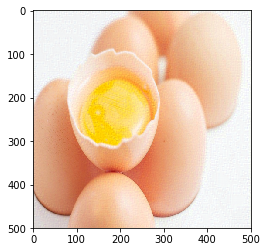

Epoch 2/5


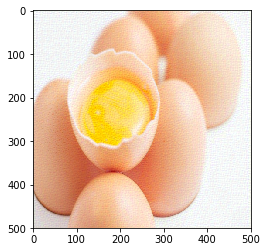

Epoch 3/5


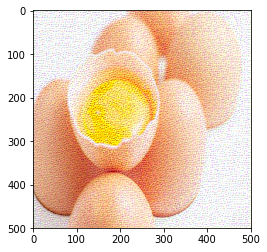

Epoch 4/5


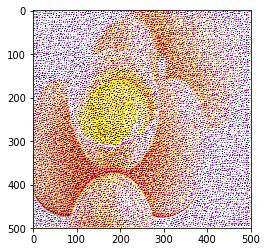

Epoch 5/5


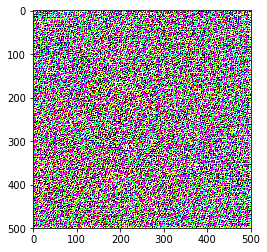

In [44]:
grads = K.gradients(loss, comb_img)[0]
f = K.function([comb_img], [loss, grads])

NUM_ITERATIONS = 5
LEARNING_RATE = 0.001

content_img4d = preprocess(content_img_value)
for i in range(NUM_ITERATIONS):
    print("Epoch {:d}/{:d}".format(i+1, NUM_ITERATIONS))
    loss_value, grads_value = f([content_img4d])
    content_img4d += grads_value * LEARNING_RATE 
    plt.imshow(deprocess(content_img4d))
    plt.show()
